In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Input, Reshape, Conv3DTranspose, UpSampling3D, LSTM
from tensorflow.keras.optimizers import Adamax
from skimage.util import random_noise
from skimage.metrics import structural_similarity, mean_squared_error
from scipy.ndimage import rotate
from skimage.transform import resize
import nibabel as nib
from ipywidgets import interact, IntSlider, RadioButtons
import time
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def label_img(img):
  return [0]

def rotateit(image, theta, isseg=False):
  order = 0 if isseg == True else 5
  return ndimage.rotate(image, float(theta), reshape=False, order=order, mode='nearest')

def data_nii_to_npy_2():
  dataset_array = []
  dataset_labels = []
  count = 0

  img_path = "/content/drive/My Drive/FYP_1/"
  saveimg_path = "/content/drive/My Drive/"

  img_names = os.listdir(img_path)
  shuffle(img_names)
  for img_name in img_names:
     # print(img_name)
      img_new = nib.load(img_path + img_name)#load
      #img = np.array(img)
      imag_data_nparray = img_new.get_fdata()
      label_current_image=label_img(img_name)
      imag_data_nparray=resize(imag_data_nparray,(32,32,32))
      imag_data_nparray = imag_data_nparray.astype('float32') / 255.0
      count +=1
      print(count)
      dataset_array.append(imag_data_nparray)
      dataset_labels.append(label_current_image)

  dataset_array = np.array(dataset_array)
  dataset_labels = np.array(dataset_labels)
  return dataset_array, dataset_labels

# Resuidal block BN -> relu -> conv -> bn -> relu -> conv
def res_block(x, filters):
    bn1 = BatchNormalization()(x)
    act1 = Activation('relu')(bn1)
    conv1 = Conv3D(filters=filters, kernel_size=(3, 3, 3),  strides=(2, 2, 2), padding='same',
                   kernel_initializer=glorot_uniform(seed=0))(act1)
    #print('conv1.shape', conv1.shape)
    bn2 = BatchNormalization()(conv1)
    act2 = Activation('relu')(bn2)
    conv2 = Conv3D(filters=filters, kernel_size=(3, 3, 3),  strides=(1, 1, 1), padding='same',
                   kernel_initializer=glorot_uniform(seed=0))(act2)
    #print('conv2.shape', conv2.shape)
    residual = Conv3D(1, (1, 1, 1), strides=(1, 1, 1))(conv2)


    x = Conv3D(filters=filters, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same',
                   kernel_initializer=glorot_uniform(seed=0))(x)
    #print('x.shape', x.shape)
    out = Add()([x, residual])

    return out

# Resuidal block BN -> relu -> conv -> bn -> relu -> conv
def deres_block1(x, filters):
    bn1 = BatchNormalization()(x)
    dn1 = Dense(4096)(bn1)
    rn1 = Reshape((2, 2, 2, 512))(dn1)
    act1 = Activation('relu')(rn1)
    conv1 = Conv3DTranspose(filters=filters, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same',
                   kernel_initializer=glorot_uniform(seed=0))(act1)
    #print('conv1.shape', conv1.shape)
    bn2 = BatchNormalization()(conv1)
    act2 = Activation('relu')(bn2)
    conv2 = Conv3DTranspose(filters=filters, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same',
                   kernel_initializer=glorot_uniform(seed=0))(act2)
    #print('conv2.shape', conv2.shape)
    residual = Conv3DTranspose(1, (1, 1, 1), strides=(1, 1, 1))(conv2)


    x = Conv3DTranspose(filters=filters, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same',
                   kernel_initializer=glorot_uniform(seed=0))(rn1)
    #print('x.shape', x.shape)
    out = Add()([x, residual])

    return out

## Resuidal block BN -> relu -> conv -> bn -> relu -> conv
def deres_block2(x, filters):
    bn1 = BatchNormalization()(x)
    act1 = Activation('relu')(bn1)
    conv1 = Conv3DTranspose(filters=filters, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same',
                   kernel_initializer=glorot_uniform(seed=0))(act1)
    #print('conv1.shape', conv1.shape)
    bn2 = BatchNormalization()(conv1)
    act2 = Activation('relu')(bn2)
    conv2 = Conv3DTranspose(filters=filters, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same',
                   kernel_initializer=glorot_uniform(seed=0))(act2)
    #print('conv2.shape', conv2.shape)
    residual = Conv3DTranspose(1, (1, 1, 1), strides=(1, 1, 1))(conv2)


    x = Conv3DTranspose(filters=filters, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same',
                   kernel_initializer=glorot_uniform(seed=0))(x)
    #print('x.shape', x.shape)
    out = Add()([x, residual])

    return out

## Resuidal block BN -> relu -> conv -> bn -> relu -> conv
def deres_block3(x, filters):
    bn1 = BatchNormalization()(x)
    conv1 = Conv3DTranspose(filters=filters, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same',
                   kernel_initializer=glorot_uniform(seed=0))(bn1)
    #print('conv1.shape', conv1.shape)
    bn2 = BatchNormalization()(conv1)
    conv2 = Conv3DTranspose(filters=filters, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same',
                   kernel_initializer=glorot_uniform(seed=0))(bn2)
    #print('conv2.shape', conv2.shape)
    residual = Conv3DTranspose(1, (1, 1, 1), strides=(1, 1, 1))(conv2)


    x = Conv3DTranspose(filters=filters, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same',
                   kernel_initializer=glorot_uniform(seed=0))(x)
    #print('x.shape', x.shape)
    out = Add()([x, residual])

    return out

In [ ]:
data , labels = data_nii_to_npy_2()

In [ ]:
np.save("data.npy", data)
np.save("labels.npy", labels)

In [ ]:
train_dataset_array = np.load("data.npy")
train_dataset_array_labels = np.load("labels.npy",allow_pickle=True)

print(train_dataset_array.shape)
print(train_dataset_array_labels.shape)

(227, 32, 32, 32)
(227, 1)


In [ ]:
# partition the data into training and testing splits using 70% of
# the data for training and the remaining 30% for testing
(trainX, testX, trainY, testY) = train_test_split(train_dataset_array, train_dataset_array_labels, test_size=0.30, stratify=train_dataset_array_labels)
X_train = trainX
X_test = testX

In [ ]:
#ResNet

input1 = Input(shape=(32,32,32,1))
input2 = Input(shape=(512))

#Image Dimension
IMAGE_DIM=(32,32,32,1)

# Combining resuidal blocks into a network
res1 = res_block(input1, 64)
res2 = res_block(res1, 128)
res3 = res_block(res2, 256)
res4 = res_block(res3, 512)

deres1 = deres_block1(input2, 512)
deres2 = deres_block2(deres1, 256)
deres3 = deres_block2(deres2, 128)
deres4 = deres_block3(deres3, 64)


#Required Feature vector size after encoding
ENCODED_SIZE=512

def ConvAutoEncoder(img_dim, encoded_size):
    #Encoder Part
    act1 = Activation('relu')(res4)
    flatten1 = Flatten()(act1)
    dense1 = Dense(encoded_size)(flatten1)

    enc = Model(inputs=input1, outputs=dense1)

    #Decoder Part

    dec = Model(inputs=input2, outputs=deres4)
    return enc, dec

encoder, decoder = ConvAutoEncoder(img_dim=IMAGE_DIM, encoded_size=ENCODED_SIZE)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 32,  0                                            
__________________________________________________________________________________________________
batch_normalization_32 (BatchNo (None, 32, 32, 32, 1 4           input_5[0][0]                    
__________________________________________________________________________________________________
activation_35 (Activation)      (None, 32, 32, 32, 1 0           batch_normalization_32[0][0]     
__________________________________________________________________________________________________
conv3d_32 (Conv3D)              (None, 16, 16, 16, 6 1792        activation_35[0][0]              
____________________________________________________________________________________________

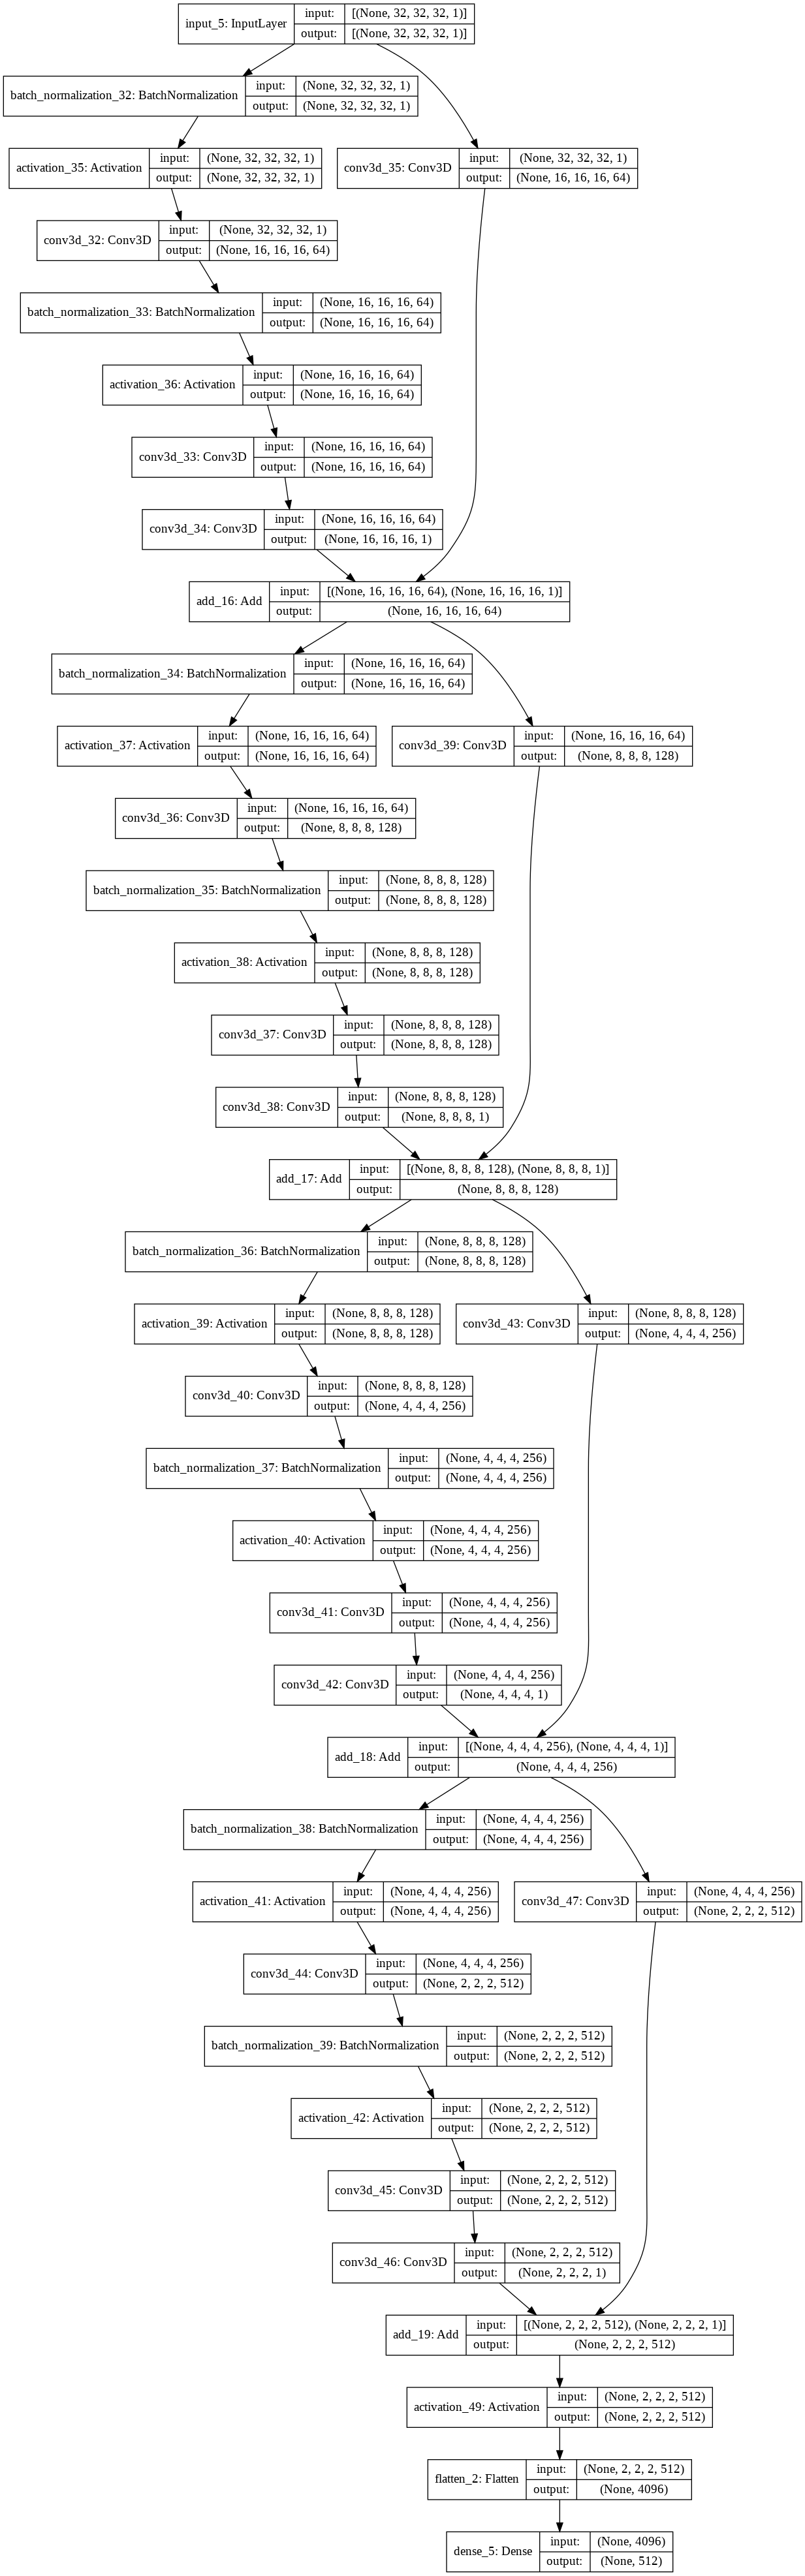

In [ ]:
encoder.summary()
plot_model(encoder, show_shapes=True, show_layer_names=True)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 512)          2048        input_6[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 4096)         2101248     batch_normalization_40[0][0]     
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 2, 2, 2, 512) 0           dense_4[0][0]                    
____________________________________________________________________________________________

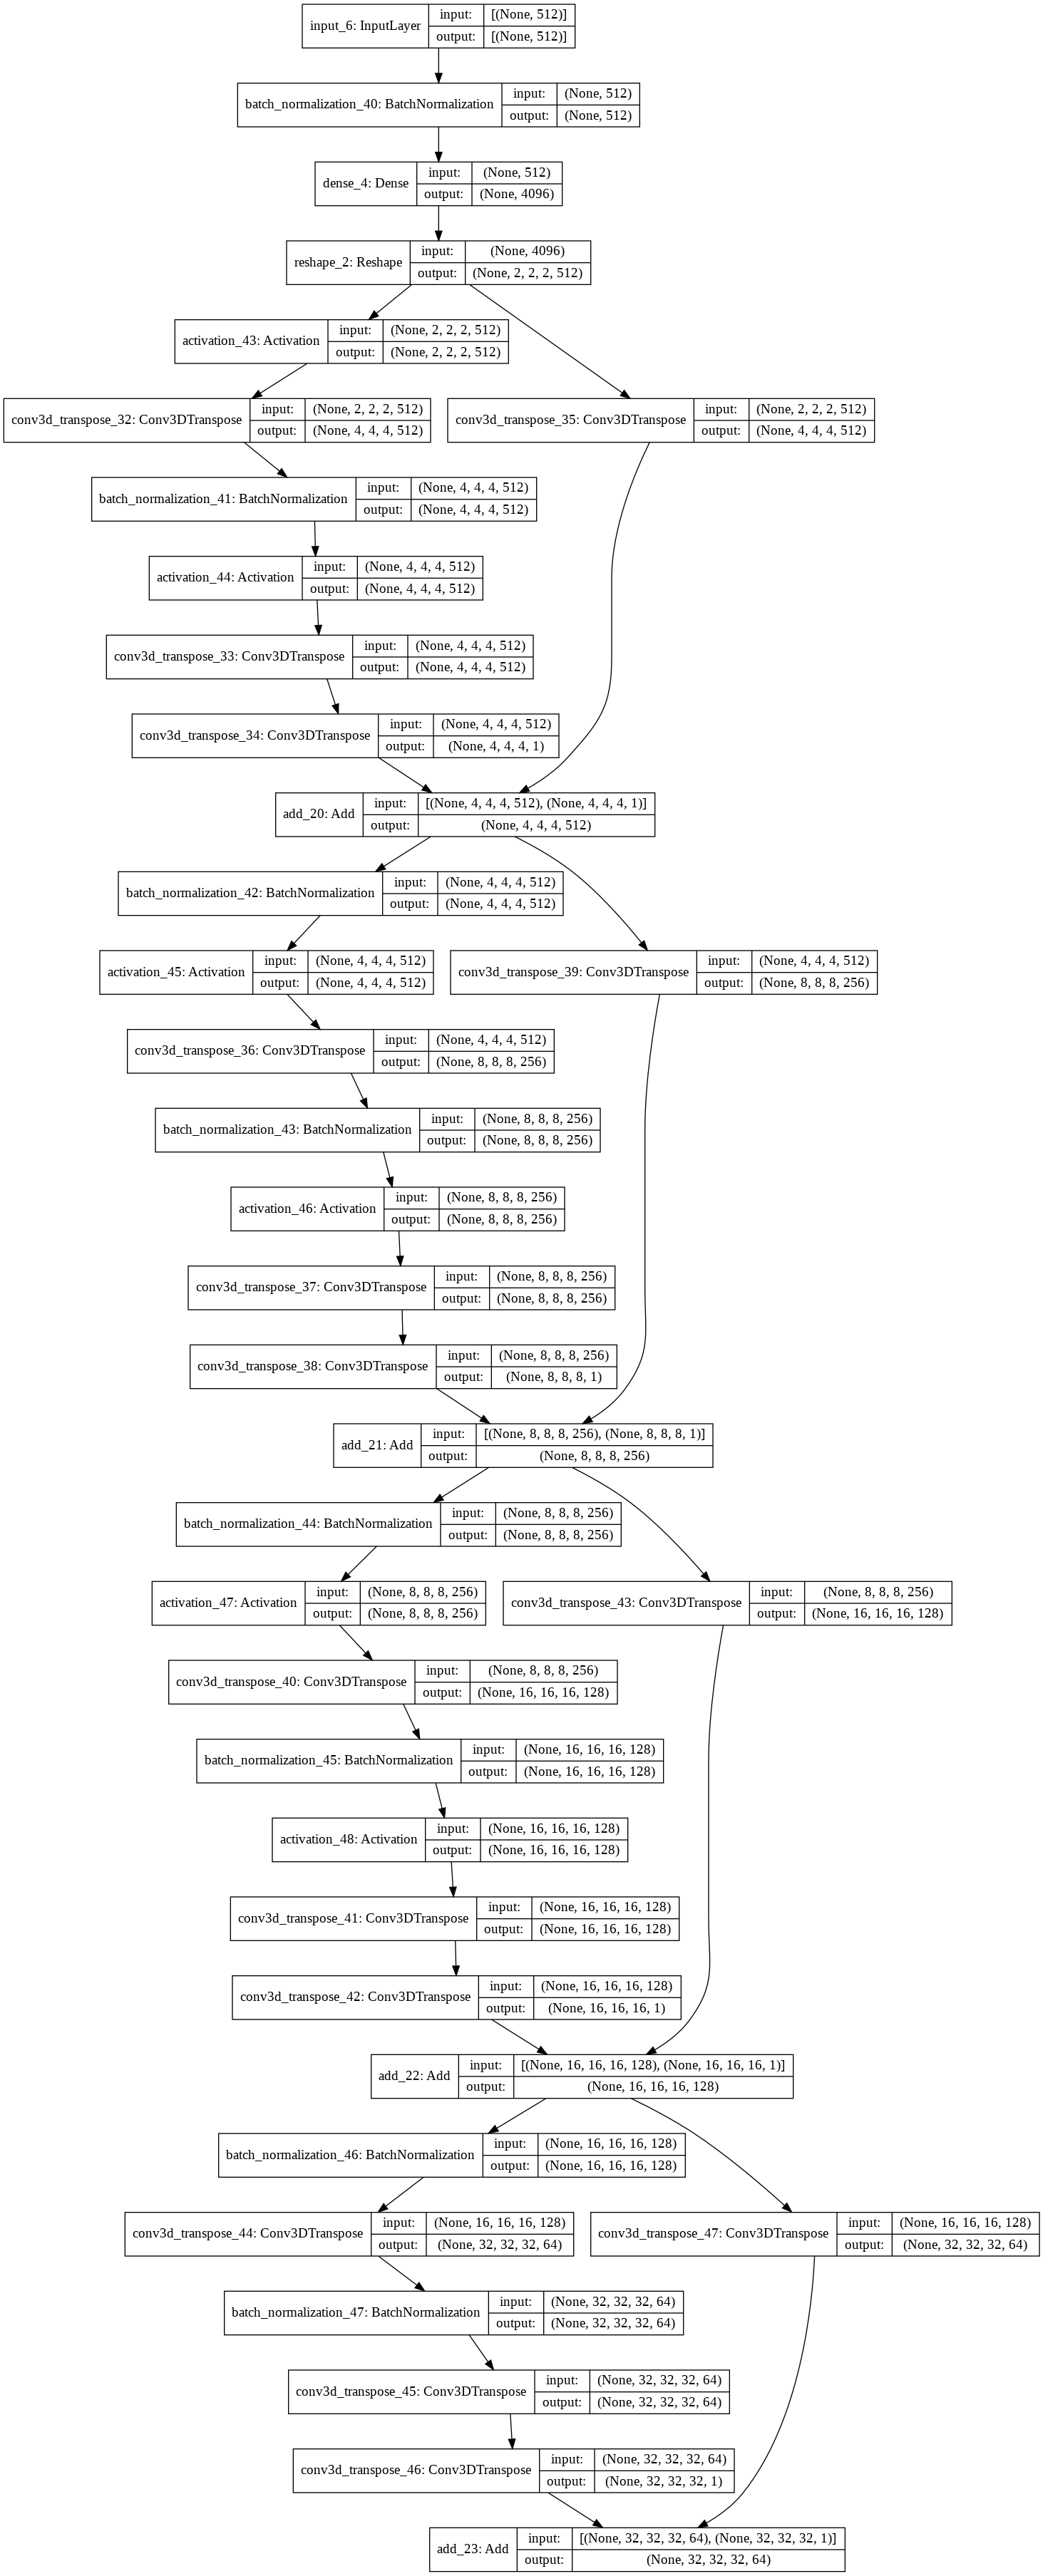

In [ ]:
decoder.summary()
plot_model(decoder, show_shapes=True, show_layer_names=True)

In [ ]:
input = Input(IMAGE_DIM)
encoded = encoder(input)
decoded = decoder(encoded)

cae = keras.models.Model(inputs=input, outputs=decoded)
cae.compile(optimizer='adamax', loss='mean_squared_error')

In [ ]:
#size is reduced to less due to GPU limit
X_train = X_train.reshape(X_train.shape[0],32,32,32,1)
X_test = X_test.reshape(X_test.shape[0],32,32,32,1)

In [ ]:
cae.fit(X_train, X_train, batch_size=4, epochs=200, verbose=1, validation_data=(X_test, X_test))

Epoch 1/200
40/40 [==============================] - 11s 220ms/step - loss: 1.5239 - val_loss: 1.2368
Epoch 2/200
40/40 [==============================] - 8s 199ms/step - loss: 1.3638 - val_loss: 1.0082
Epoch 3/200
40/40 [==============================] - 8s 202ms/step - loss: 1.4249 - val_loss: 1.6660
Epoch 4/200
40/40 [==============================] - 8s 203ms/step - loss: 1.5321 - val_loss: 1.4042
Epoch 5/200
40/40 [==============================] - 8s 203ms/step - loss: 1.3851 - val_loss: 2.2188
Epoch 6/200
40/40 [==============================] - 8s 201ms/step - loss: 1.1349 - val_loss: 1.2762
Epoch 7/200
40/40 [==============================] - 8s 200ms/step - loss: 1.2438 - val_loss: 1.0078
Epoch 8/200
40/40 [==============================] - 8s 198ms/step - loss: 0.9624 - val_loss: 0.9344
Epoch 9/200
40/40 [==============================] - 8s 198ms/step - loss: 1.6204 - val_loss: 1.4944
Epoch 10/200
40/40 [==============================] - 8s 198ms/step - loss: 1.1346 - val_l

Training Loss:  0.5296675562858582
Validation Loss:  0.5409266948699951


Text(0.5, 1.0, 'Training and validation loss')

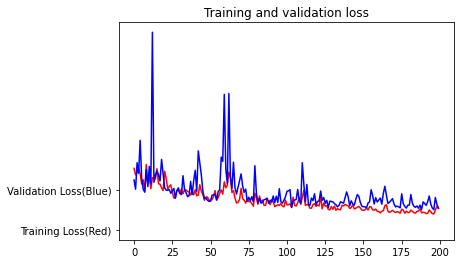

In [ ]:
loss=cae.history.history['loss']
val_loss=cae.history.history['val_loss']

print("Training Loss: ",loss[-1])
print("Validation Loss: ",val_loss[-1])
epochs=range(len(loss)) # Get number of epochs

plt.figure()
plt.plot(epochs, loss, 'r', "Training Loss(Red)")
plt.plot(epochs, val_loss, 'b', "Validation Loss(Blue)")
plt.title('Training and validation loss')

In [ ]:
#Save model for later use
cae.save('ResCoder.h5')

In [ ]:
# Load the trained Model
#from keras.models import load_model
cae = load_model('ResCoder.h5')

In [ ]:
# Extract 'Encoder' Part from it
encoder = cae.layers[1]

images = X_train
codes = encoder.predict(images)

In [ ]:
from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
def get_similar(image, n_neighbors=5):

    code = encoder.predict(image[None])

    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)

    return distances,images[idx]

def show_similar(image):
    start_time = time.time()
    distances,neighbors = get_similar(image,n_neighbors=5)

    print("                                     \033[1m"+"QUERY IMAGE"+"\033[0m")
    #Show given image
    ImageSliceViewer3D(image.reshape(32,32,32,))

    print("                                    \033[1m"+"RETRIEVED IMAGES"+"\033[0m")
    for i in range(4):
        ImageSliceViewer3D(neighbors[i+1].reshape(32,32,32))
        print("Dist={:.3f}".format(distances[i+1]))
    plt.show()
    end_time = time.time()
    exec_time = end_time-start_time
    print("Execution Time (in seconds):",exec_time)

class ImageSliceViewer3D:
    def __init__(self, volume, figsize=(3,3), cmap='gray'):
        self.volume = volume
        self.figsize = figsize
        self.cmap = cmap
        self.v = [np.min(volume), np.max(volume)]

        # Call to select slice plane
        interact(self.view_selection, view=RadioButtons(
            options=['x-y','y-z', 'z-x'], value='x-y',
            description='Slice plane selection:', disabled=False,
            style={'description_width': 'initial'}))

    def view_selection(self, view):
        # Transpose the volume to orient according to the slice plane selection
        orient = {"y-z":[1,2,0], "z-x":[2,0,1], "x-y": [0,1,2]}
        self.vol = np.transpose(self.volume, orient[view])
        maxZ = self.vol.shape[2] - 1

        # Call to view a slice within the selected slice plane
        interact(self.plot_slice,
            z=IntSlider(min=0, max=maxZ, step=1, continuous_update=False,
            description='Image Slice:'))

    def plot_slice(self, z):
        # Plot slice for the given plane and slice
        self.fig = plt.figure(figsize=self.figsize)
        plt.imshow(self.vol[:,:,z], cmap=plt.get_cmap(self.cmap),
            vmin=self.v[0], vmax=self.v[1])

In [ ]:
show_similar(X_test[22])

                                     QUERY IMAGE


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

                                    RETRIEVED IMAGES


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

Dist=15899.584


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

Dist=18884.384


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

Dist=19473.947


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

Dist=20273.507
Execution Time (in seconds): 0.9784848690032959


In [ ]:
def show_similar2d(image):
    start_time = time.time()
    distances,neighbors = get_similar(image,n_neighbors=5)

    print("                                     \033[1m"+"QUERY IMAGE"+"\033[0m")
    #Show given image
    plt.imshow(image[:,:,5].reshape(32,32),cmap='gray')
    plt.title("Slice 5")
    plt.show()

    print("                                    \033[1m"+"RETRIEVED IMAGES"+"\033[0m")
    plt.figure(figsize=(20, 20))
    for i in range(4):
        ax = plt.subplot(1, 5, i+1)
        plt.imshow(neighbors[i+1][:,:,5].reshape(32,32),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Dist={:.3f} (Slice 5)".format(distances[i+1]))
    plt.show()
    end_time = time.time()
    exec_time = end_time-start_time
    print("Execution Time (in seconds):",exec_time)


                                     QUERY IMAGE


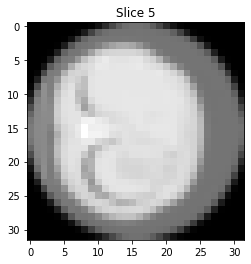

                                    RETRIEVED IMAGES


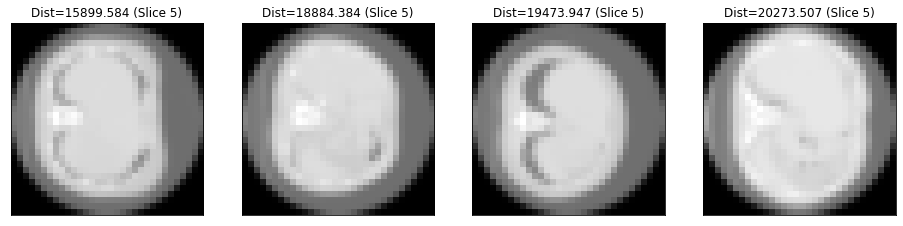

Execution Time (in seconds): 0.4027698040008545


In [ ]:
show_similar2d(X_test[22])